<!-- ## Mounting drive and copying the dataset

Below datasets are datasets used for random forest propensity and
random forest classification model training

Datasets contain anomalous and normal meshes with calculated per 
point distance from relevant reference mesh point.

Also contained within are train and test dataframes for mesh model. -->

In [ ]:
# from google.colab import drive

# # Mount google drive with datasets and models
# drive.mount('/content/drive')
# # Copy models from drive to notebook directory "/content/"
# !cp "/content/drive/MyDrive/ma-vqc_datasets/Quartered anomaly size.zip" "/content" # Full mesh dataset
# !cp "/content/drive/MyDrive/ma-vqc_datasets/RF Quartered anomaly size.zip" "/content" # Point dataset

# # Run to extract dataset files

# # zip_name will be used for loading and saving datasets. Make sure the name is correct
# zip_name = "Quartered anomaly size"
# with zipfile.ZipFile(f"/content/{zip_name}.zip", 'r') as zip_ref: 
#     zip_ref.extractall("/content/")

# with zipfile.ZipFile(f"/content/RF {zip_name}.zip", 'r') as zip_ref: 
#     zip_ref.extractall("/content/")


Mounted at /content/drive


## Requirements

In [33]:
import os
import random

import pandas as pd
import zipfile
import glob
from joblib import dump, load
import open3d as o3d

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np

from notebook_utils.propensity_utils import get_reference_pairs, generate_distance_csvs


random.seed = 42

## Point model data preparation

### Generate 2 datasets using script.
Make sure the datasets have different paths when generating and that the parameters for anomalies are the same

One dataset is for training the Random Forest propensity model
The second one used for per mesh classification

This function is used to generate a dataframe used for training per propensity model.
<ul>
<li><b>id</b> - unique mesh identifier</li>
<li><b>dist</b> - distance value of item point to relevant reference mesh point</li>
<li><b>label</b> - per point label for whether the point is on an anomaly</li>
<li><b>label_obj</b> - whether the mesh contains an anomaly</li>
</ul>

In [34]:
# Load csv files with per point values of ['x', 'y', 'z', 'dist', 'label']
def get_samples(paths, labels):
  # Create point dataframe
  columns_list = ['id', 'x', 'y', 'z', 'dist', 'label', 'label_obj']
  point_df = pd.DataFrame(columns=columns_list)
  for idx, (name, label) in enumerate(zip(paths, labels)):
      if name.endswith(".csv"):

        # Loading point dataframe of single point cloud 
        df_tmp = pd.read_csv(name)
        df_tmp['id'] = idx
        df_tmp['label_obj'] = 0 if label=="normal" else 1
        
        # Concatenate to single dataframe
        point_df = pd.concat([point_df, df_tmp], ignore_index=True)                
  return point_df

def data_split(paths_anom, paths_norm, test_split, point=True):
   
  # Calculate data split
  split_ids = int(len(paths_anom) * test_split)
  print(f"Anoms: {len(paths_anom)}")
  print(f"Norms: {len(paths_norm)}")

  # Split train and test paths per class
  train_paths_anom = paths_anom[split_ids:]
  train_paths_norm = paths_norm[split_ids:]
  test_paths_anom = paths_anom[:split_ids]
  test_paths_norm = paths_norm[:split_ids]

  train_labels = [1 for _ in range(len(train_paths_anom))] + [0 for _ in range(len(train_paths_norm))]
  test_labels = [1 for _ in range(len(test_paths_anom))] + [0 for _ in range(len(test_paths_norm))]
  train_point_df = get_samples(train_paths_anom + train_paths_norm, train_labels)
  train_point_df.to_csv("./data/train_point_df.csv", index=False)

  # Test dataset
  test_point_df = get_samples(test_paths_anom + test_paths_norm, test_labels)
  test_point_df.to_csv("./data/test_point_df.csv", index=False)

  # 90/10 class split
  anom_split_90_10 = int(len(test_paths_anom)/9)
  test_paths_anom_90_10 = test_paths_anom[:anom_split_90_10]
  test_labels_90_10 = [1 for _ in range(len(test_paths_anom_90_10))] + [0 for _ in range(len(test_paths_norm))]
  # 90-10 split dataset
  test_point_df_90_10 = get_samples(test_paths_anom_90_10 + test_paths_norm, test_labels_90_10)
  test_point_df_90_10.to_csv("./data/test_point_df_90_10.csv", index=False)

  return train_point_df, test_point_df, test_point_df_90_10


In [35]:
paths_of_point_clouds = "C:/Users/Sani/Desktop/WorkTest/point_cloud_mesh/" # Insert path to point cloud folder of propensity dataset
test_split = 0.2 # test split for propensity data

In [39]:

# Get matching reference to anomaly/normal mesh
pairs_of_paths = get_reference_pairs(
    {"anomaly": [], 'normal': []},
    paths_of_point_clouds
)
# Generate distance csvs to be used for propensity model training
df_point = generate_distance_csvs(
    pairs_of_paths,
    os.path.join(paths_of_point_clouds, "generate_distance_csvs")
)
train_point_df, test_point_df, test_point_df_90_10 = data_split(df_point["anomaly"], df_point["normal"], test_split)

Anoms: 20
Norms: 20


### Point anomaly dataset

Point anomaly dataset contains csv files with columns ["x", "y", "z", "dist"]
where dist is the per point distance to the relevant mesh point

This dataset is used for training propensity random forest model

## Point model training

To train propensity random forest model should be loaded in the following cell.
Set contains ["x", "y", "z", "dist", "id", "label_obj", "label"] values per point for all meshes.

**id** - unique mesh id

**label** - 1 if point is on anomaly else 0

**label_obj** - 1 if mesh has anomaly else 0 for all points in mesh

In [21]:
# Load dataframes for point net training
train_point_df = pd.read_csv("./data/train_point_df.csv")
test_point_df = pd.read_csv("./data/test_point_df.csv")
test_point_df_90_10 = pd.read_csv("./data/test_point_df_90_10.csv")
print(train_point_df.shape)
print(test_point_df.shape)
print(test_point_df_90_10.shape)

(1287744, 7)
(321936, 7)
(160968, 7)


In [22]:
# Fraction of ids to be used for training
frac_of_ids = 0.2

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished


matplotlib data path: c:\Users\Sani\anaconda3\envs\ma-vqc-data-preprocessing\lib\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\Sani\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\Sani\.matplotlib
Using fontManager instance from C:\Users\Sani\.matplotlib\fontlist-v330.json
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='c:\\Users\\Sani\\anaconda3\\envs\\ma-vqc-data-preprocessing\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\Sani\\anaconda3\\envs\\ma-vqc-data-preprocessing\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeF

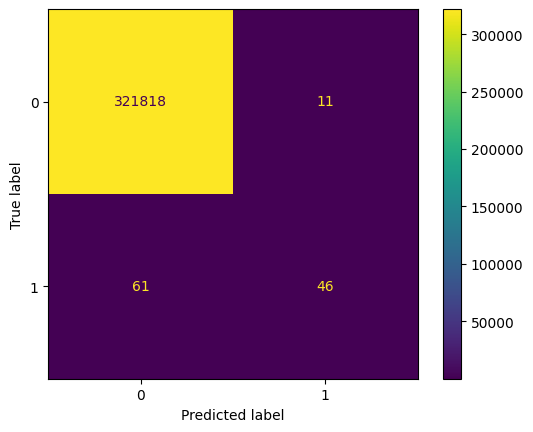

In [23]:
selected_ids = np.random.choice(
    train_point_df['id'].unique(), 
    int(frac_of_ids*len(train_point_df['id'].unique())), 
    replace=False
)
# Select subsample for Random Forest point training
df_anomaly_point = train_point_df.loc[train_point_df.id.isin(selected_ids)]
#  Save dataframe for reproducibility
df_anomaly_point.to_csv("./data/selected_train_points.csv")

# Train Random Forest point model
features = df_anomaly_point.loc[:, ['x','y','z','dist']].values 
labels =  df_anomaly_point.loc[:, 'label'].values 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
rf_point = RandomForestClassifier(verbose=1, n_jobs=2) 
rf_point.fit(features, labels)

# Plot results of model on test data sample
test_features = test_point_df.loc[:, ['x','y','z','dist']].values 
test_labels =  test_point_df.loc[:, 'label'].values 
test_pred = rf_point.predict(test_features)

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(cm)

### Model weights transfered to drive 
Transfer to own drive for it to be used for PointNet if RF point sampling is to be used for predictions

In [24]:
# Save point model
model_save_path = "./model_weights"
os.makedirs(model_save_path, exist_ok=True)
dump(rf_point, f'{model_save_path}/rf_point.joblib') 

['./model_weights/rf_point.joblib']

Test 90-10 evaluation

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


locator: <matplotlib.ticker.AutoLocator object at 0x0000022D29097910>


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


[[160963      5]
 [     0      0]]


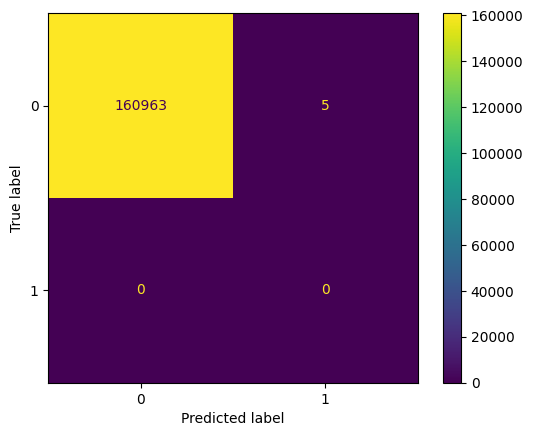

In [25]:
# Plot results of model on test data sample
test_features_90_10 = test_point_df_90_10.loc[:, ['x','y','z','dist']].values 
test_labels_90_10 =  test_point_df_90_10.loc[:, 'label'].values 
test_pred_90_10 = rf_point.predict(test_features_90_10)

# Plot Confusion Matrix
cm_90_10 = confusion_matrix(test_labels_90_10, test_pred_90_10)
ConfusionMatrixDisplay(confusion_matrix=cm_90_10).plot()
print(cm_90_10)

# Point cloud model dataset preparation

Once point model is trained we train mesh classification model on the mesh dataset

### Point aggregation

For the mesh we generate a separate dataset where we use the trained rf_point model to predict the porability of anomalies per point.

We then use those predictions and the distance metrics to get percentiles for each mesh to get input features for our random forest classifier
Each row represents a mesh with label_obj_is_anom as label for the mesh and the different percentiles we calculate

In [61]:
# Here we create dataframe from second dataset
path_mesh_point_cloud = "C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh"

# Get matching reference to anomaly/normal mesh
pairs_of_paths_mesh = get_reference_pairs(
    {"anomaly": [], 'normal': []},
    path_mesh_point_cloud
)
# Generate distance csvs to be used for propensity model training
df = generate_distance_csvs(
    pairs_of_paths_mesh,
    os.path.join(path_mesh_point_cloud, "generate_distance_csvs")
)

In [94]:
pairs_of_paths_mesh

{'anomaly': [['C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\anomaly\\anomaly_lattice_test4_v0.csv',
   'C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\reference\\reference_lattice_test4.csv'],
  ['C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\anomaly\\anomaly_lattice_test4_v1.csv',
   'C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\reference\\reference_lattice_test4.csv'],
  ['C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\anomaly\\anomaly_lattice_test4_v2.csv',
   'C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\reference\\reference_lattice_test4.csv'],
  ['C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\anomaly\\anomaly_lattice_test4_v3.csv',
   'C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\reference\\reference_lattice_test4.csv'],
  ['C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\\anomaly\\anomaly_lattice_test4_v4.csv',
   'C:/Users/Sani/Desktop/WorkTest/mesh data/point_clo

In [110]:
def create_mesh_dataframe(pairs_of_paths_mesh, df):
    data_dict = {"object_path": [], "reference_path": [], "label": []}
    for key in ["anomaly", "normal"]:
        for i in range(len(df[key])):
            data_dict["object_path"].append(pairs_of_paths_mesh[key][i][0].replace("csv", "pcd"))
            data_dict["reference_path"].append(df[key][i])
            data_dict["label"].append(key)
    return pd.DataFrame(data_dict)

def create_mesh_split(pairs_of_paths_mesh, df, test_split):
    df = create_mesh_dataframe(pairs_of_paths_mesh, df)

    df_anom = df[df["label"] == "anomaly"]
    df_norm = df[df["label"] == "normal"]

    split_idx = int(df_anom.shape[0] * test_split)

    train_df = pd.concat([
        df_anom.iloc[split_idx:],
        df_norm.iloc[split_idx:]

    ], ignore_index=False)

    test_df = pd.concat([
        df_anom.iloc[:split_idx],
        df_norm.iloc[:split_idx]
    ], ignore_index=False)

    test_df_90_10 = pd.concat([
        df_anom.iloc[:int(split_idx/9)],
        df_norm.iloc[:split_idx]
    ], ignore_index=False)
    train_df.to_csv("./data/train_df.csv", index=False)
    test_df.to_csv("./data/test_df.csv", index=False)
    test_df_90_10.to_csv("./data/test_df_90_10.csv", index=False)

    return train_df, test_df, test_df_90_10


In [111]:
mesh_test_split = 0.2

In [112]:
train_df, test_df, test_point_df_90_10 = create_mesh_split(pairs_of_paths_mesh, df, mesh_test_split)

C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v0.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v1.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v2.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v3.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v4.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v5.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v6.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v7.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v8.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_cloud_mesh\anomaly\anomaly_lattice_test4_v9.csv
C:/Users/Sani/Desktop/WorkTest/mesh data/point_clo

In [103]:
%%capture
#Aggregate data for training the model to detect anomaly mesh

# Calculating percentile of items per dataset
def percentile(n):
  """
  Calculates percentile values per mesh in dataframe
  """
  def percentile_(x):
      return np.percentile(x, n)
  percentile_.__name__ = 'percentile_%s' % n
  return percentile_


def is_anom(series):
  """
  Function used for labelling entire dataset maximum value
  of label_obj column
  """
  # If maximum value is set to anomaly
  return series.max()

def aggregate_data(df):
  """
  Function used to aggregate points per mesh into
  1 row with percentile information for dist and prob_anom
  columns columns and preserves label_obj as label for classification
  """
  aggr_df = df.groupby(['id']).agg(
      {'label_obj': is_anom,
      'dist':[
          'mean',
          'max',
          percentile(60),
          percentile(70),
          percentile(80),
          percentile(90),
          percentile(95),
          percentile(96),
          percentile(97),
          percentile(98),
          percentile(99),
      ],
      'prob_anom':[
          'mean',  
          'max', 
          percentile(60),
          percentile(70),
          percentile(80),
          percentile(90),
          percentile(95),
          percentile(96),
          percentile(97),
          percentile(98),
          percentile(99),
      ],
      }
  )
  aggr_df.columns = ['_'.join(col) for col in aggr_df.columns.values]
  return aggr_df

def create_aggregated_dataset(df, rf_point):
  # Load test data
  dataset = None
  for idx, (name, label) in enumerate(zip(df["reference_path"], df["label"])):
      if name.endswith(".csv"):
        # Loading dataframe of file
          df_tmp = pd.read_csv(name)
          df_tmp['id'] = idx
          df_tmp['label_obj'] = 1 if label == "anomaly" else 0

          df_tmp["prob_anom"] = rf_point.predict_proba(df_tmp.loc[:, ['x', 'y', 'z', 'dist']].values)[:,1]
          # Selecting uniformly distributed indices
          if isinstance(dataset, type(None)):
              dataset = aggregate_data(df_tmp)
          else:
              dataset = pd.concat([dataset,
                                aggregate_data(df_tmp)],
                                ignore_index=True)
  return dataset


train_anomaly_mesh = create_aggregated_dataset(train_df, rf_point)
print("Train done")
test_anomaly_mesh = create_aggregated_dataset(test_df, rf_point)
print("Test done")
print(train_anomaly_mesh["label_obj_is_anom"].value_counts())
print(test_anomaly_mesh["label_obj_is_anom"].value_counts())

# Save aggregated dataset for further use of RandomForest+PointNet

train_anomaly_mesh.to_csv("./data/aggregated_train.csv", index=False) 
test_anomaly_mesh.to_csv("./data/aggregated_test.csv", index=False) 

Transfering aggregated metrics to drive for further use by PointNet+RandomForest model 

Do not run if only training Stacked Random Forest model

In [104]:
# # Create data split 90/10 for test set to be used for this and other model testing

# # Select indices of test set dataframe 50/50 split and select anomaly indices for reduction
# anom_split_90_10 = int(test_df[test_df["label"] == "anomaly"].shape[0]/9)
# print(f"Number of anomaly samples: {anom_split_90_10}")

# normal_inds = []
# anomaly_inds = []
# for idx, label in enumerate(test_df["label"]):
#   if label == "anomaly":
#     anomaly_inds.append(idx)
#   else:
#     normal_inds.append(idx)

# # Select indices to be used for 90/10 split
# anomaly_inds = np.random.choice(anomaly_inds, size=anom_split_90_10, replace=False)

# # Concatenate files
# test_df_90_10 = pd.concat([test_df.iloc[normal_inds],
#                           test_df.iloc[anomaly_inds]])

# # Save dataframe and transfer to drive for further use
# test_df_90_10.to_csv("test_df_90_10.csv", index=False)
# # !cp "test_df_90_10.csv" "/content/drive/MyDrive/MA-VQC Data/Quartered Anomaly Size/RandomForestData" 



Random Forest training and Evaluation

locator: <matplotlib.ticker.AutoLocator object at 0x0000022D27244370>
[[4 0]
 [1 3]]


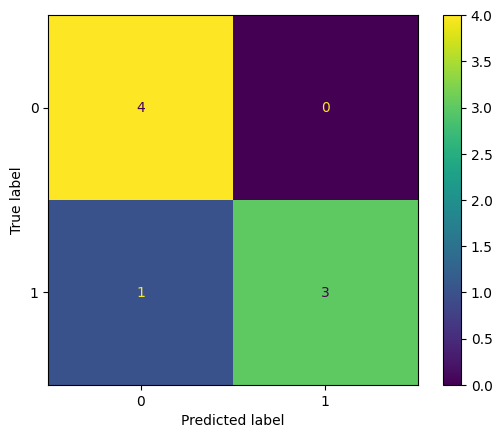

In [105]:
# Train model for random forest classifier for detecting anomalous meshes

train_features_mesh = train_anomaly_mesh.loc[:, train_anomaly_mesh.columns[1:]].values
train_labels_mesh = train_anomaly_mesh.loc[:, 'label_obj_is_anom'].values.astype(int)

test_features_mesh = test_anomaly_mesh.loc[:, train_anomaly_mesh.columns[1:]].values
test_labels_mesh = test_anomaly_mesh.loc[:, 'label_obj_is_anom'].values.astype(int)

# Fit model
rf_mesh = RandomForestClassifier()
rf_mesh.fit(train_features_mesh, train_labels_mesh)

test_pred_mesh = rf_mesh.predict(test_features_mesh)
# Create the confusion matrix to plot results
cm = confusion_matrix(test_labels_mesh, test_pred_mesh)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(cm)

In [106]:
# Transfer model for use in PointNet with RF downsampling selection
dump(rf_mesh, f'{model_save_path}/rf_mesh.joblib') 
# !cp "/content/model_weights/rf_mesh_50-50.joblib" "/content/drive/MyDrive/MA-VQC Data/Quartered Anomaly Size/RandomForestModels" #/90-10"

['./model_weights/rf_mesh.joblib']

90-10 anomaly split

colorbar update normal <matplotlib.colors.Normalize object at 0x0000022D27769E40> <matplotlib.colors.Normalize object at 0x0000022D27769E40>
locator: <matplotlib.ticker.AutoLocator object at 0x0000022D271BB280>
colorbar update normal <matplotlib.colors.Normalize object at 0x0000022D27769E40> <matplotlib.colors.Normalize object at 0x0000022D27769E40>
locator: <matplotlib.ticker.AutoLocator object at 0x0000022D271BB280>
locator: <matplotlib.ticker.AutoLocator object at 0x0000022D271BA8C0>
[[4]]


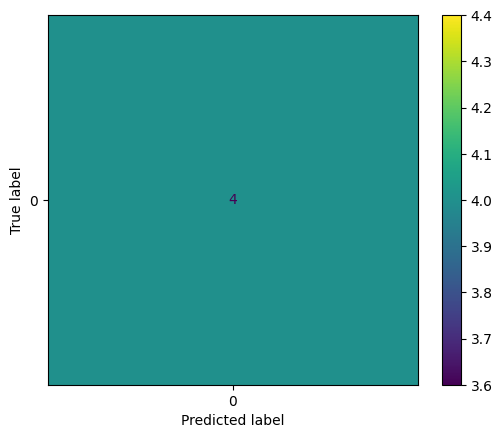

In [107]:
# Results for 90/10 split of dataset

# Create the confusion matrix to plot results
# !cp "/content/drive/MyDrive/MA-VQC Data/Quartered Anomaly Size/RandomForestData/test_df_90_10.csv" "/content/"
test_point_df_90_10 = pd.read_csv("./data/test_df_90_10.csv")

# Match indices of selected 90/10 dataframe
inds = [idx for idx, name in enumerate(test_df["reference_path"]) if name in test_point_df_90_10["reference_path"].tolist()]
test_anomaly_mesh_90_10 = test_anomaly_mesh.iloc[inds]


test_features_mesh_90_10 = test_anomaly_mesh_90_10.loc[:, test_anomaly_mesh_90_10.columns[1:]].values
test_labels_mesh_90_10 = test_anomaly_mesh_90_10.loc[:, 'label_obj_is_anom'].values.astype(int)
test_pred_mesh_90_10 = rf_mesh.predict(test_features_mesh_90_10)

cm = confusion_matrix(test_labels_mesh_90_10, test_pred_mesh_90_10)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(cm)